### Imports
Warning: May run ten's of minutes (i.e. 10, 20 etc. up to an hour) on relatively fast machine. X-core + a lot of RAM required. Do not try VM

In [123]:
from IPython.core.display import HTML
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
HTML("<style>.container { width:75% !important; }</style>")
# HTML("<style>div.cell.selected {border-left-width: 1px !important;}</style>")

In [124]:
%load_ext cython
%load_ext cythonmagic
%matplotlib inline
%matplotlib notebook

import pandas as pd
import numpy as np
import scipy as sp

from scipy import * 

import re, reprlib, sys
import matplotlib.pyplot as plt
from itertools import *
import random as ran
from logging import *
from pprint import *
from time import *
import shlex, subprocess


from scipy.cluster.vq import *

import nltk as n
import nltk, nltk.classify.util, nltk.metrics, nltk.tokenize, nltk.stem
from nltk.corpus import *
from nltk.stem import *
from nltk.classify import *
from nltk.collocations import *
from nltk.metrics import *
from nltk.probability import *
from nltk.classify.scikitlearn import *
from nltk.tag.sequential import *
from nltk.tag import *
from nltk.tag.util import *
# n.download()

# from sklearn_pandas import *

import sklearn as sk
from sklearn import *
from sklearn.feature_extraction.text import *
from sklearn.svm import *
from sklearn.preprocessing import *
from sklearn.cross_validation import *
from sklearn.pipeline import *
from sklearn.multiclass import *
from sklearn.datasets import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.feature_selection import *
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.grid_search import *
from sklearn.base import *
from sklearn.datasets.twenty_newsgroups import *
from sklearn.decomposition import *
from sklearn.feature_extraction import *
from sklearn.metrics import *
from sklearn.utils import *

sk.utils.check_random_state(5125)
ran.seed(5125)

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The cythonmagic extension is already loaded. To reload it, use:
  %reload_ext cythonmagic


### Random functions
##### plot_roc_curve

In [125]:
def plot_roc_curve(test_class, y_score, name, trait):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr, tpr, _ = roc_curve(test_class, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC chart with ' + name + " algorithm and on" + trait + " dataset")
    plt.legend(loc="lower right")
    plt.show()

##### train_test_at_once

In [126]:
columns_data = ["StringLength", 
          "Number_of_Words", "Number_of_Dots", "Number_of_Commas", "Number_of_Semicolons", 
          "Number_of_Colons", "Average_Word_Length", "Lexical_Diversity", 
          "Number_of_FunctionalWords", "Number_of_Pronouns", "Number_of_PROPNAMEs", 
          "SentimentNumeric"]

columns_data2 = ["STATUS", "StringLength", 
          "Number_of_Words", "Number_of_Dots", "Number_of_Commas", "Number_of_Semicolons", 
          "Number_of_Colons", "Average_Word_Length", "Lexical_Diversity", 
          "Number_of_FunctionalWords", "Number_of_Pronouns", "Number_of_PROPNAMEs", 
          "SentimentNumeric"]

In [127]:
def train_test_at_once(nick_names, classifiers, trait_input, train_feat_trait, test_feat_trait, 
                       train_class_trait, test_class_trait, trait_X, trait_Y, skf_trait):
    
    for name, clf in zip(nick_names, classifiers):
        clf.fit(train_feat_trait[columns_data], train_class_trait)
        y_pred_trait = clf.predict(test_feat_trait[columns_data])

        if (type(MultinomialNB()) == type(clf) or 
            type(BernoulliNB()) == type(clf) or 
            type(KNeighborsClassifier()) == type(clf) or 
            type(RandomForestClassifier()) == type(clf) or 
            type(AdaBoostClassifier()) == type(clf) or 
            type(SVC()) == type(clf)):
            y_score_trait =  clf.predict_proba(test_feat_trait[columns_data])
            plot_roc_curve(test_class_trait, y_score_trait, name, trait_input)

        print("\nFOR:", name)
        print(sk.metrics.classification_report(test_class_trait, y_pred_trait, labels=[0, 1], target_names=["0", "1"]))
        print(sk.metrics.confusion_matrix(test_class_trait, y_pred_trait, labels=[0, 1]))
        print("F1: ", sk.metrics.f1_score(test_class_trait, y_pred_trait, labels=[0, 1], average='binary'))
        print("Precision: ", sk.metrics.average_precision_score(test_class_trait, y_pred_trait, average='micro'))
        print("Recall: ", sk.metrics.recall_score(test_class_trait, y_pred_trait, labels=[0, 1], average='binary'))

        np.savetxt("/home/jm/Documents/caseSolvingSeminar/raw_data/y_pred_class_labels/" + trait_input + "_pred" + name + ".csv", y_pred_trait, delimiter=",", fmt='%1.0f')

        scores = sk.cross_validation.cross_val_score(clf, trait_X[columns_data], trait_Y, cv=skf_trait, scoring='accuracy')
        print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std()*2, name))
        print("Accuracy score: ", sk.metrics.accuracy_score(test_class_trait, y_pred_trait))

In [128]:
def train_test_at_once_pipes(pipes, trait_input, train_feat_trait, test_feat_trait, 
                             train_class_trait, test_class_trait, trait_X, trait_Y, skf_trait):
    
    pipes.fit(train_feat_trait[columns_data2], train_class_trait)
    y_pred_trait = pipes.predict(test_feat_trait[columns_data2])

    y_score_trait =  pipes.predict_proba(test_feat_trait[columns_data2])
    plot_roc_curve(test_class_trait, y_score_trait, "Pipeline", trait_input)
    
    print("\nFOR: Pipeline: ")
    print(sk.metrics.classification_report(test_class_trait, y_pred_trait, labels=[0, 1], target_names=["0", "1"]))
    print(sk.metrics.confusion_matrix(test_class_trait, y_pred_trait, labels=[0, 1]))
    print("F1: ", sk.metrics.f1_score(test_class_trait, y_pred_trait, labels=[0, 1], average='binary'))
    print("Precision: ", sk.metrics.average_precision_score(test_class_trait, y_pred_trait, average='micro'))
    print("Recall: ", sk.metrics.recall_score(test_class_trait, y_pred_trait, labels=[0, 1], average='binary'))

    scores = sk.cross_validation.cross_val_score(pipes, trait_X[columns_data2], trait_Y, cv=skf_trait, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std()*2, "pipeline"))
    print("Accuracy score: ", sk.metrics.accuracy_score(test_class_trait, y_pred_trait))

### R script adding new features to dataset 

In [129]:
# http://www.mango-solutions.com/wp/2015/10/integrating-python-and-r-part-ii-executing-r-from-python-and-vice-versa/
command = 'Rscript'
path2script = 'insert_features.R'

cmd = [command, path2script]

subprocess.check_output(cmd, universal_newlines=True)

''

In [130]:
data_n = pd.read_csv("../raw_data/data_n.csv", parse_dates=True, infer_datetime_format=True)
data_n.head(n=2)

,Unnamed: 0,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,...,Number_of_Dots,Number_of_Commas,Number_of_Semicolons,Number_of_Colons,Average_Word_Length,Lexical_Diversity,Number_of_FunctionalWords,Number_of_Pronouns,Number_of_PROPNAMEs,SentimentNumeric
0,1,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3,3.15,3.25,4.4,n,y,...,1,0,0,0,4.400,0.700,2,0,0,2
1,2,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,2.65,3,3.15,3.25,4.4,n,y,...,1,0,0,0,3.615,0.577,10,1,0,0


### Replace 'y' and 'n'   AND easy split

In [131]:
# http://stackoverflow.com/a/17702781
d = {'n': 0, 'y': 1} # 1, y, = TRUE             0, n = FALSE
data_n = data_n.replace(d)
data_n.head(n=1)

,Unnamed: 0,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,...,Number_of_Dots,Number_of_Commas,Number_of_Semicolons,Number_of_Colons,Average_Word_Length,Lexical_Diversity,Number_of_FunctionalWords,Number_of_Pronouns,Number_of_PROPNAMEs,SentimentNumeric
0,1,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3,3.15,3.25,4.4,0,1,...,1,0,0,0,4.4,0.7,2,0,0,2


In [132]:
#norm:http://blog.yhat.com/posts/predicting-customer-churn-with-sklearn.html
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# to_drop = ['State','Area Code','Phone','Churn?']
# churn_feat_space = data_n.drop(to_drop,axis=1)

In [133]:
neu = data_n[["#AUTHID","STATUS","cNEU","StringLength", 
                  "Number_of_Words", "Number_of_Dots", "Number_of_Commas", "Number_of_Semicolons", 
                  "Number_of_Colons", "Average_Word_Length", "Lexical_Diversity", "Number_of_FunctionalWords", "Number_of_Pronouns", "Number_of_PROPNAMEs", "SentimentNumeric"]]
ext = data_n[["#AUTHID","STATUS","cEXT", "StringLength", 
                  "Number_of_Words", "Number_of_Dots", "Number_of_Commas", "Number_of_Semicolons", 
                  "Number_of_Colons", "Average_Word_Length", "Lexical_Diversity", "Number_of_FunctionalWords", "Number_of_Pronouns", "Number_of_PROPNAMEs", "SentimentNumeric"]]
agr = data_n[["#AUTHID","STATUS","cAGR","StringLength", 
                  "Number_of_Words", "Number_of_Dots", "Number_of_Commas", "Number_of_Semicolons", 
                  "Number_of_Colons", "Average_Word_Length", "Lexical_Diversity", "Number_of_FunctionalWords", "Number_of_Pronouns", "Number_of_PROPNAMEs", "SentimentNumeric"]]
con = data_n[["#AUTHID","STATUS","cCON","StringLength", 
                  "Number_of_Words", "Number_of_Dots", "Number_of_Commas", "Number_of_Semicolons", 
                  "Number_of_Colons", "Average_Word_Length", "Lexical_Diversity", "Number_of_FunctionalWords", "Number_of_Pronouns", "Number_of_PROPNAMEs", "SentimentNumeric"]]
opn = data_n[["#AUTHID","STATUS","cOPN", "StringLength", 
                  "Number_of_Words", "Number_of_Dots", "Number_of_Commas", "Number_of_Semicolons", 
                  "Number_of_Colons", "Average_Word_Length", "Lexical_Diversity", "Number_of_FunctionalWords", "Number_of_Pronouns", "Number_of_PROPNAMEs", "SentimentNumeric"]]

### Split stratified k-folds

In [134]:
# neu = data_n[["#AUTHID","STATUS","cNEU"]]
# train_neu, test_neu, y_train, y_test = sk.cross_validation.train_test_split(neu, neu["cNEU"], train_size = 0.66, stratify= neu["cNEU"])
# train_neu, test_neu, y_train, y_test 

In [135]:
train_feat_neu, test_feat_neu, train_class_neu, test_class_neu = sk.cross_validation.train_test_split(neu, neu["cNEU"], train_size = 0.66, stratify = neu["cNEU"],random_state= 5152)
print(train_feat_neu.shape, test_feat_neu.shape,train_class_neu.shape ,test_class_neu.shape)

neu_X = train_feat_neu.append(test_feat_neu)
neu_Y = train_class_neu.append(test_class_neu)

train_feat_ext, test_feat_ext, train_class_ext, test_class_ext = sk.cross_validation.train_test_split(ext, ext["cEXT"], train_size = 0.66, stratify = ext["cEXT"],random_state= 5152)

ext_X = train_feat_ext.append(test_feat_ext)
ext_Y = train_class_ext.append(test_class_ext)

train_feat_agr, test_feat_agr, train_class_agr, test_class_agr = sk.cross_validation.train_test_split(agr, agr["cAGR"], train_size = 0.66, stratify = agr["cAGR"],random_state= 5152)

agr_X = train_feat_agr.append(test_feat_agr)
agr_Y = train_class_agr.append(test_class_agr)

train_feat_con, test_feat_con, train_class_con, test_class_con = sk.cross_validation.train_test_split(con, con["cCON"], train_size = 0.66, stratify = con["cCON"],random_state= 5152)

con_X = train_feat_con.append(test_feat_con)
con_Y = train_class_con.append(test_class_con)

train_feat_opn, test_feat_opn, train_class_opn, test_class_opn = sk.cross_validation.train_test_split(opn, opn["cOPN"], train_size = 0.66, stratify = opn["cOPN"],random_state= 5152)

opn_X = train_feat_opn.append(test_feat_opn)
opn_Y = train_class_opn.append(test_class_opn)

(6545, 15) (3372, 15) (6545,) (3372,)


In [136]:
test_class_ext.to_csv("/home/jm/Documents/caseSolvingSeminar/raw_data/test_class_labels/ext_test.csv",  header=None,  encoding="utf-8")
test_class_neu.to_csv("/home/jm/Documents/caseSolvingSeminar/raw_data/test_class_labels/neu_test.csv",  header=None,  encoding="utf-8")
test_class_agr.to_csv("/home/jm/Documents/caseSolvingSeminar/raw_data/test_class_labels/agr_test.csv",  header=None,  encoding="utf-8")
test_class_con.to_csv("/home/jm/Documents/caseSolvingSeminar/raw_data/test_class_labels/con_test.csv",  header=None,  encoding="utf-8")
test_class_opn.to_csv("/home/jm/Documents/caseSolvingSeminar/raw_data/test_class_labels/opn_test.csv",  header=None,  encoding="utf-8")

In [137]:
skf_neu = StratifiedKFold(neu["cNEU"], n_folds=10, shuffle=True, random_state = 5152)
skf_ext = StratifiedKFold(ext["cEXT"], n_folds=10, shuffle=True, random_state = 5152)
skf_agr = StratifiedKFold(agr["cAGR"], n_folds=10, shuffle=True, random_state = 5152)
skf_con = StratifiedKFold(con["cCON"], n_folds=10, shuffle=True, random_state = 5152)
skf_opn = StratifiedKFold(opn["cOPN"], n_folds=10, shuffle=True, random_state = 5152)

### Types of classifiers 
with their configuration

In [138]:
nick_names = ["SVC", "LinearSVC", "Multinomia-NB", "Bernoulli-NB", "RF", "AdaB", "kNN"]
classifiers = [
    SVC(cache_size=500, kernel = "rbf", decision_function_shape = "ovr", random_state = 5152, probability = True),
    LinearSVC(random_state = 5152),
    MultinomialNB(),
    BernoulliNB(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, n_jobs=-1, random_state = 5152),
    AdaBoostClassifier(random_state = 5152),
    KNeighborsClassifier()]

#### Pipeline for STATUS and the rest

In [139]:
%run ETL.py

In [114]:
pipeline = Pipeline([     
    ('features', FeatureUnion(
          transformer_list=[
            ('ngram_tf_idf', Pipeline([
              ('selector', ColumnSelector()),
              ('counts', TfidfVectorizer(ngram_range = (1,2))),
            ])),

            ('rest', Pipeline([
              ('extract', ColumnExtractor()), 
              ('best', TruncatedSVD(n_components=9, random_state = 5152)),
            ])),   
          ],

          transformer_weights={
            'ngram_tf_idf': 1.0,
            'rest': 0.5,
          },
    )),
    ('classifier', BernoulliNB()),
])

### Train + Test NEU

read: https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case

<IPython.core.display.Javascript object>


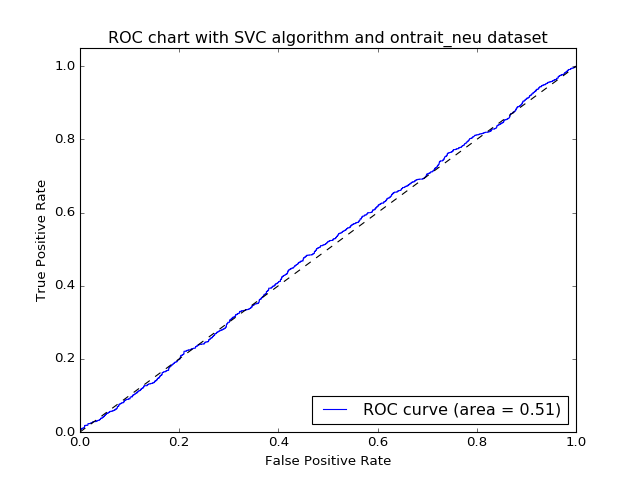


FOR: SVC
             precision    recall  f1-score   support

          0       0.62      0.94      0.75      2108
          1       0.35      0.05      0.09      1264

avg / total       0.52      0.61      0.50      3372

[[1984  124]
 [1196   68]]
F1:  0.0934065934066
Precision:  0.381324890761
Recall:  0.0537974683544
Accuracy: 0.616 (+/- 0.03) [SVC]
Accuracy score:  0.608540925267

FOR: LinearSVC
             precision    recall  f1-score   support

          0       0.57      0.03      0.05      2108
          1       0.37      0.97      0.54      1264

avg / total       0.50      0.38      0.23      3372

[[  54 2054]
 [  40 1224]]
F1:  0.538969616909
Precision:  0.676807620125
Recall:  0.96835443038
Accuracy: 0.494 (+/- 0.25) [LinearSVC]
Accuracy score:  0.379003558719


<IPython.core.display.Javascript object>


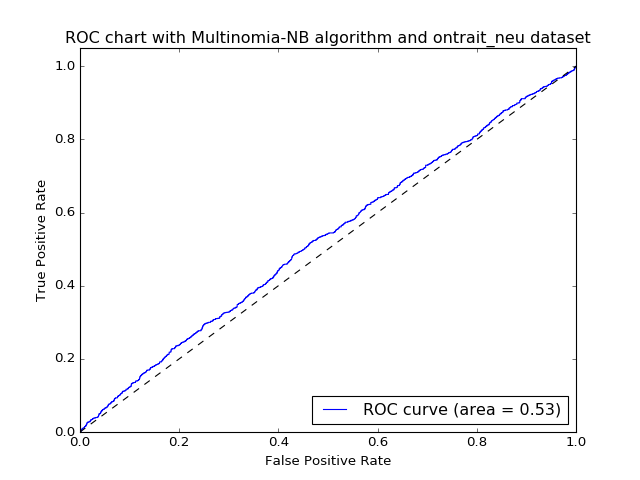


FOR: Multinomia-NB
             precision    recall  f1-score   support

          0       0.63      0.99      0.77      2108
          1       0.48      0.01      0.02      1264

avg / total       0.57      0.62      0.49      3372

[[2094   14]
 [1251   13]]
F1:  0.0201394268009
Precision:  0.431381366445
Recall:  0.0102848101266
Accuracy: 0.624 (+/- 0.02) [Multinomia-NB]
Accuracy score:  0.624851720047


<IPython.core.display.Javascript object>


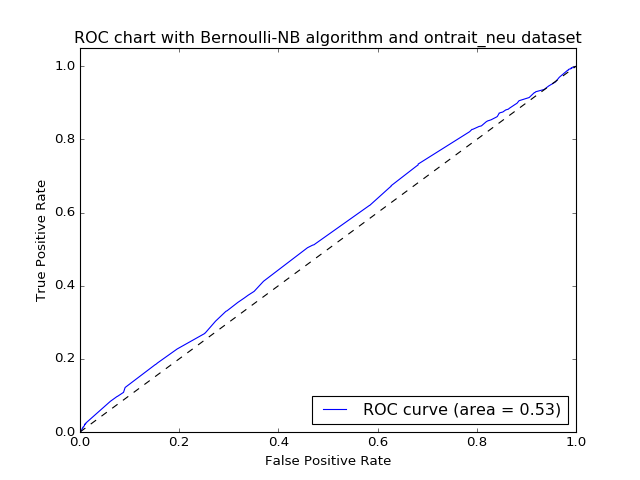


FOR: Bernoulli-NB
             precision    recall  f1-score   support

          0       0.63      1.00      0.77      2108
          1       0.40      0.00      0.01      1264

avg / total       0.54      0.62      0.48      3372

[[2102    6]
 [1260    4]]
F1:  0.00627943485086
Precision:  0.388415018695
Recall:  0.00316455696203
Accuracy: 0.625 (+/- 0.02) [Bernoulli-NB]
Accuracy score:  0.624555160142


<IPython.core.display.Javascript object>


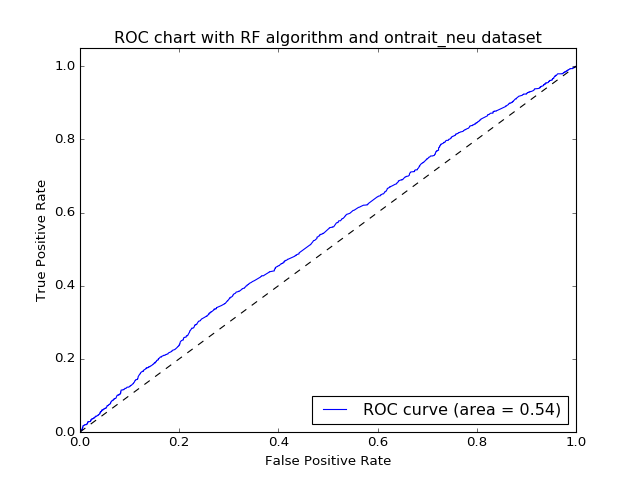


FOR: RF
             precision    recall  f1-score   support

          0       0.63      1.00      0.77      2108
          1       0.53      0.01      0.01      1264

avg / total       0.59      0.63      0.49      3372

[[2100    8]
 [1255    9]]
F1:  0.0140515222482
Precision:  0.454357349386
Recall:  0.00712025316456
Accuracy: 0.625 (+/- 0.02) [RF]
Accuracy score:  0.625444839858


<IPython.core.display.Javascript object>


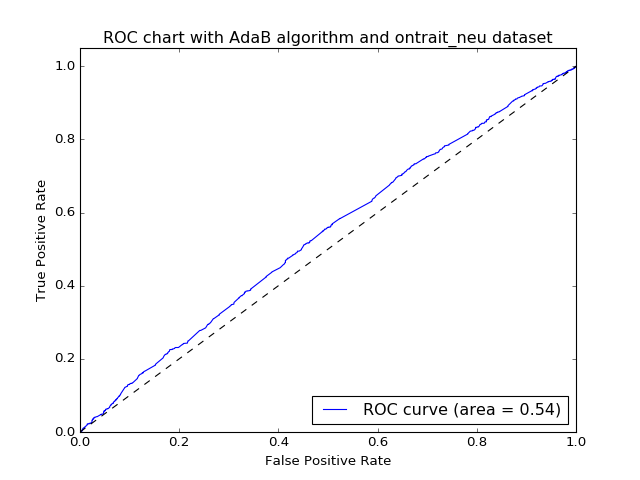


FOR: AdaB
             precision    recall  f1-score   support

          0       0.63      0.98      0.76      2108
          1       0.41      0.03      0.05      1264

avg / total       0.55      0.62      0.50      3372

[[2057   51]
 [1228   36]]
F1:  0.0532938564027
Precision:  0.403224839785
Recall:  0.0284810126582
Accuracy: 0.621 (+/- 0.02) [AdaB]
Accuracy score:  0.620699881376


<IPython.core.display.Javascript object>


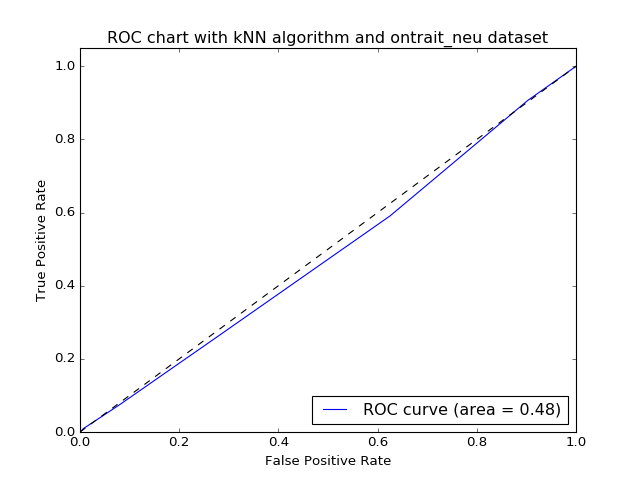


FOR: kNN
             precision    recall  f1-score   support

          0       0.62      0.73      0.67      2108
          1       0.36      0.25      0.30      1264

avg / total       0.52      0.55      0.53      3372

[[1539  569]
 [ 943  321]]
F1:  0.298050139276
Precision:  0.447142922008
Recall:  0.253955696203
Accuracy: 0.559 (+/- 0.03) [kNN]
Accuracy score:  0.551601423488


In [120]:
train_test_at_once(nick_names, classifiers, "trait_neu", train_feat_neu, 
                   test_feat_neu, train_class_neu, test_class_neu, neu_X, neu_Y, skf_neu)

#### Pipeline

<IPython.core.display.Javascript object>


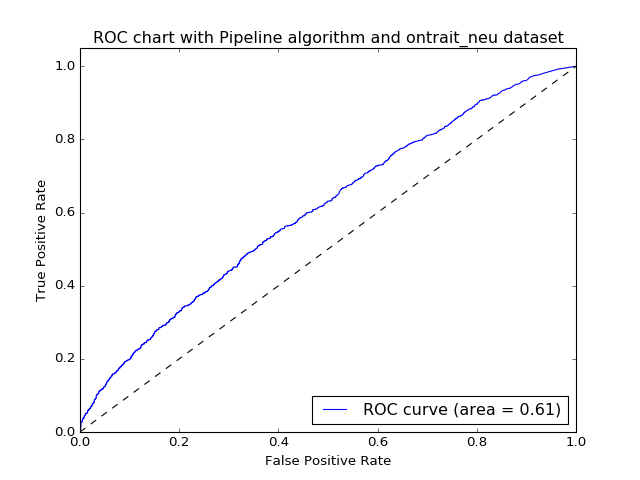


FOR: Pipeline: 
             precision    recall  f1-score   support

          0       0.63      1.00      0.77      2108
          1       0.85      0.02      0.04      1264

avg / total       0.71      0.63      0.50      3372

[[2104    4]
 [1241   23]]
F1:  0.0356312935709
Precision:  0.619039448307
Recall:  0.0181962025316
Accuracy: 0.630 (+/- 0.03) [pipeline]
Accuracy score:  0.630782918149


In [122]:
train_test_at_once_pipes(pipeline,"trait_neu", train_feat_neu, test_feat_neu, 
                   train_class_neu, test_class_neu, neu_X, neu_Y, skf_neu)

### Train + Test EXT

In [ ]:
train_test_at_once(nick_names, classifiers, "trait_ext", train_feat_ext, test_feat_ext, 
                   train_class_ext, test_class_ext, ext_X, ext_Y, skf_ext)

<IPython.core.display.Javascript object>

#### Pipeline

In [ ]:
train_test_at_once_pipes(pipeline,"trait_ext", train_feat_ext, test_feat_ext, 
                   train_class_ext, test_class_ext, ext_X, ext_Y, skf_ext)

### Train + Test CON

0.530856352036


<IPython.core.display.Javascript object>


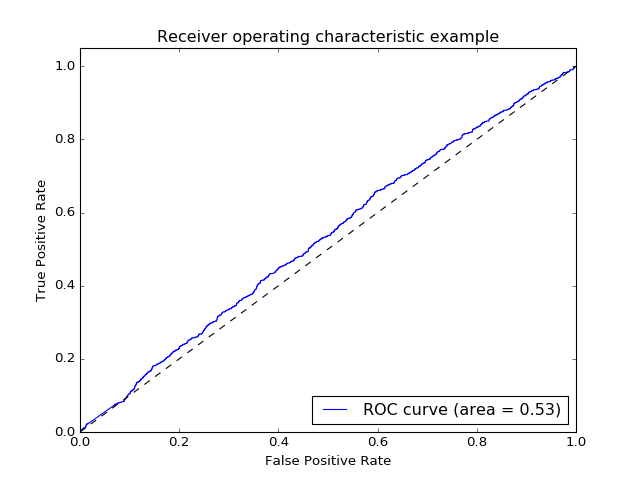


FOR: SVC
             precision    recall  f1-score   support

          0       0.55      0.71      0.62      1823
          1       0.49      0.32      0.39      1549

avg / total       0.52      0.53      0.52      3372

[[1303  520]
 [1049  500]]
F1:  0.389256520047
Precision:  0.562038157472
Recall:  0.322788896062
Accuracy: 0.532 (+/- 0.02) [SVC]
Accuracy score:  0.534697508897

FOR: LinearSVC
             precision    recall  f1-score   support

          0       0.57      0.00      0.01      1823
          1       0.46      1.00      0.63      1549

avg / total       0.52      0.46      0.29      3372

[[   8 1815]
 [   6 1543]]
F1:  0.628897493377
Precision:  0.728702797441
Recall:  0.996126533247
Accuracy: 0.515 (+/- 0.08) [LinearSVC]
Accuracy score:  0.459964412811
0.519988830761


<IPython.core.display.Javascript object>


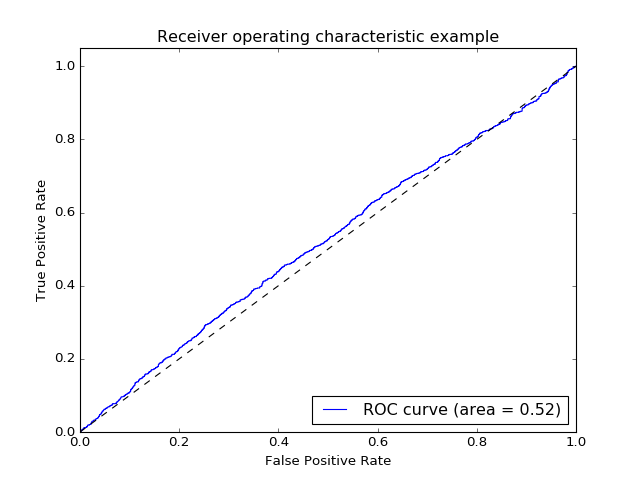


FOR: Multinomia-NB
             precision    recall  f1-score   support

          0       0.55      0.81      0.65      1823
          1       0.49      0.21      0.30      1549

avg / total       0.52      0.54      0.49      3372

[[1476  347]
 [1220  329]]
F1:  0.295730337079
Precision:  0.530442284182
Recall:  0.212395093609
Accuracy: 0.532 (+/- 0.03) [Multinomia-NB]
Accuracy score:  0.535290628707
0.530866090593


<IPython.core.display.Javascript object>


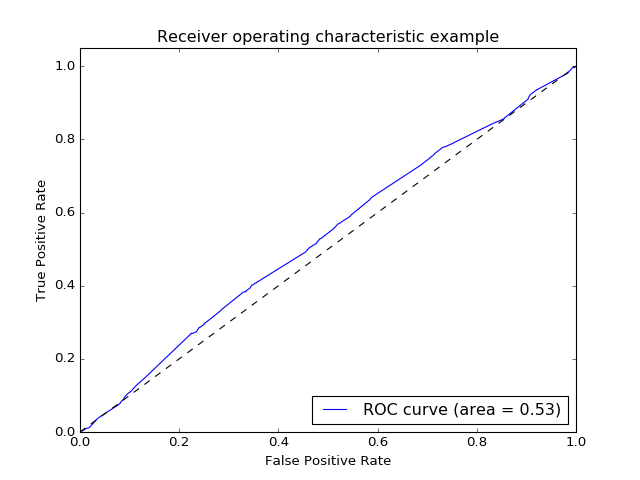


FOR: Bernoulli-NB
             precision    recall  f1-score   support

          0       0.56      0.77      0.65      1823
          1       0.50      0.27      0.35      1549

avg / total       0.53      0.54      0.51      3372

[[1411  412]
 [1131  418]]
F1:  0.351408154687
Precision:  0.554437613804
Recall:  0.269851517108
Accuracy: 0.542 (+/- 0.04) [Bernoulli-NB]
Accuracy score:  0.542408066429
0.538232866249


<IPython.core.display.Javascript object>


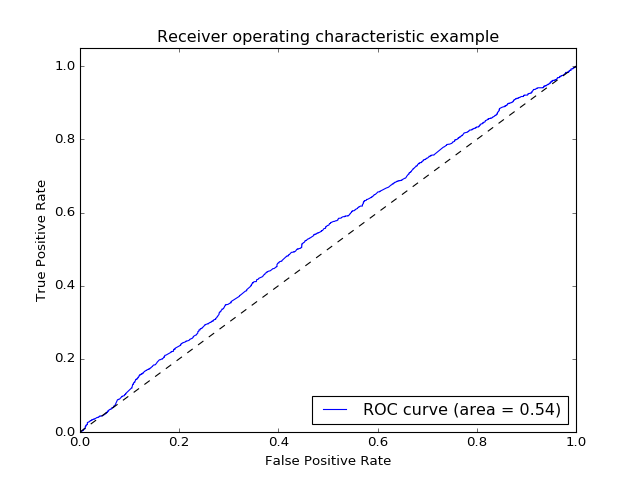


FOR: RF
             precision    recall  f1-score   support

          0       0.54      0.94      0.69      1823
          1       0.46      0.06      0.10      1549

avg / total       0.50      0.54      0.42      3372

[[1720  103]
 [1461   88]]
F1:  0.101149425287
Precision:  0.475408925676
Recall:  0.0568108457069
Accuracy: 0.547 (+/- 0.03) [RF]
Accuracy score:  0.536180308422
0.539990941371


<IPython.core.display.Javascript object>


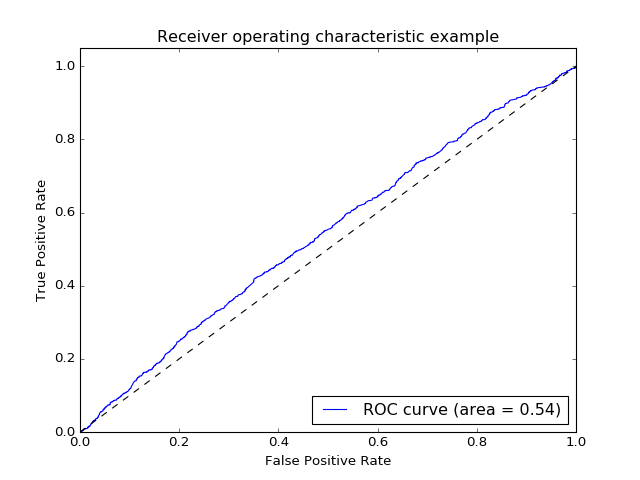


FOR: AdaB
             precision    recall  f1-score   support

          0       0.55      0.82      0.66      1823
          1       0.51      0.22      0.31      1549

avg / total       0.53      0.54      0.50      3372

[[1492  331]
 [1208  341]]
F1:  0.307068887888
Precision:  0.542913434333
Recall:  0.220142027114
Accuracy: 0.542 (+/- 0.03) [AdaB]
Accuracy score:  0.54359430605
0.536170416955


<IPython.core.display.Javascript object>


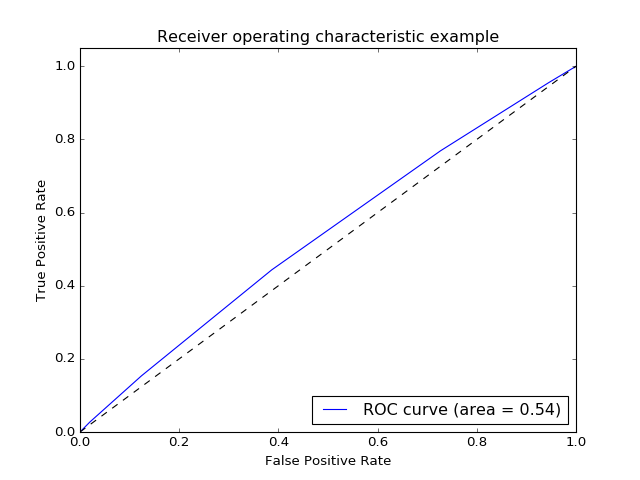


FOR: kNN
             precision    recall  f1-score   support

          0       0.56      0.61      0.59      1823
          1       0.49      0.44      0.47      1549

avg / total       0.53      0.54      0.53      3372

[[1118  705]
 [ 862  687]]
F1:  0.467188031282
Precision:  0.596340532072
Recall:  0.443511943189
Accuracy: 0.522 (+/- 0.03) [kNN]
Accuracy score:  0.535290628707


In [17]:
train_test_at_once(nick_names, classifiers, "trait_con", train_feat_con, test_feat_con, train_class_con, test_class_con, con_X, con_Y, skf_con)

### Train + Test AGR

0.480648198474


<IPython.core.display.Javascript object>


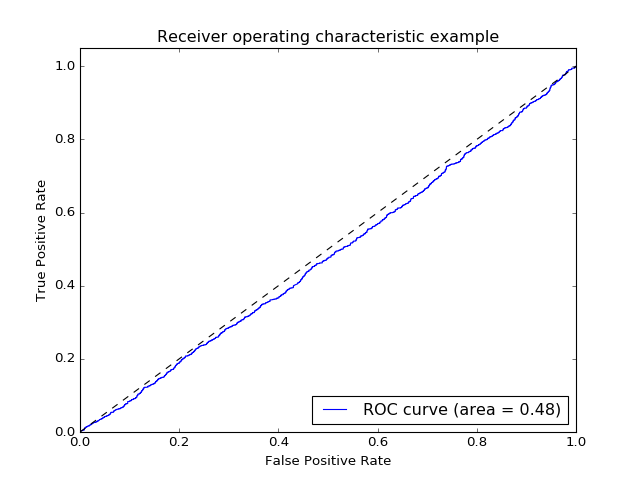


FOR: SVC
             precision    recall  f1-score   support

          0       0.49      0.34      0.40      1581
          1       0.54      0.68      0.60      1791

avg / total       0.51      0.52      0.51      3372

[[ 545 1036]
 [ 578 1213]]
F1:  0.600495049505
Precision:  0.694018856476
Recall:  0.677275265215
Accuracy: 0.514 (+/- 0.02) [SVC]
Accuracy score:  0.521352313167

FOR: LinearSVC
             precision    recall  f1-score   support

          0       0.54      0.01      0.02      1581
          1       0.53      0.99      0.69      1791

avg / total       0.53      0.53      0.38      3372

[[  15 1566]
 [  13 1778]]
F1:  0.692502434275
Precision:  0.764147664282
Recall:  0.992741485204
Accuracy: 0.503 (+/- 0.07) [LinearSVC]
Accuracy score:  0.531731909846
0.524501063191


<IPython.core.display.Javascript object>


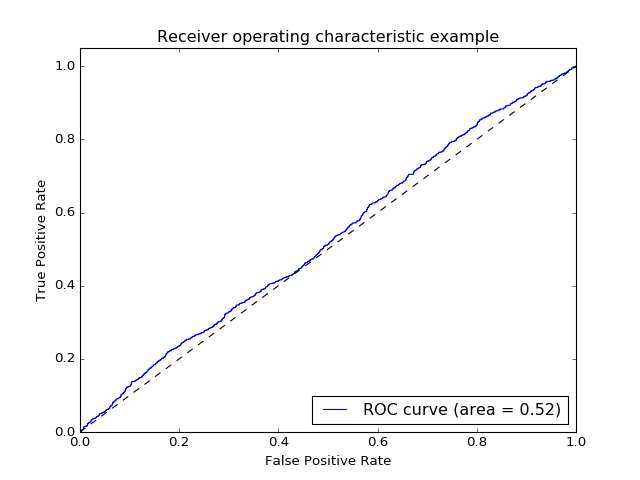


FOR: Multinomia-NB
             precision    recall  f1-score   support

          0       0.54      0.16      0.24      1581
          1       0.54      0.88      0.67      1791

avg / total       0.54      0.54      0.47      3372

[[ 251 1330]
 [ 218 1573]]
F1:  0.670217298679
Precision:  0.742391802453
Recall:  0.878280290341
Accuracy: 0.527 (+/- 0.03) [Multinomia-NB]
Accuracy score:  0.540925266904
0.554181936459


<IPython.core.display.Javascript object>


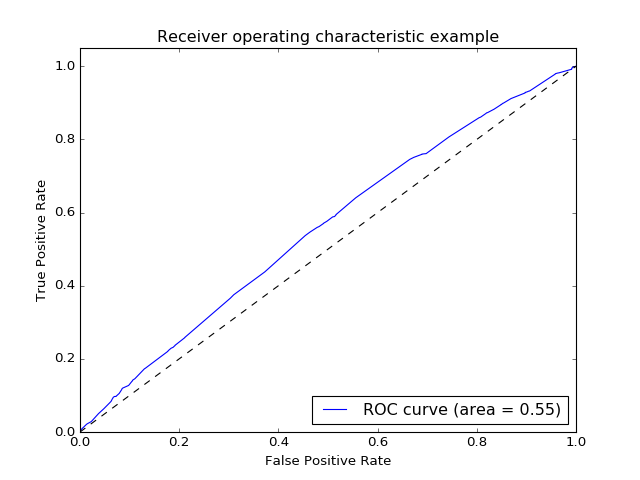


FOR: Bernoulli-NB
             precision    recall  f1-score   support

          0       0.56      0.18      0.27      1581
          1       0.55      0.87      0.67      1791

avg / total       0.55      0.55      0.48      3372

[[ 285 1296]
 [ 228 1563]]
F1:  0.672258064516
Precision:  0.743503562131
Recall:  0.87269681742
Accuracy: 0.538 (+/- 0.03) [Bernoulli-NB]
Accuracy score:  0.548042704626
0.554546928189


<IPython.core.display.Javascript object>


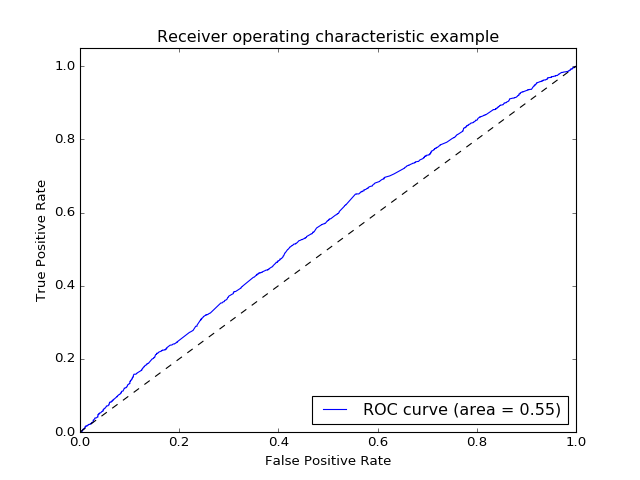


FOR: RF
             precision    recall  f1-score   support

          0       0.55      0.16      0.25      1581
          1       0.54      0.89      0.67      1791

avg / total       0.55      0.55      0.47      3372

[[ 252 1329]
 [ 205 1586]]
F1:  0.674033149171
Precision:  0.745207959222
Recall:  0.885538805137
Accuracy: 0.539 (+/- 0.03) [RF]
Accuracy score:  0.545077105575
0.549324032489


<IPython.core.display.Javascript object>


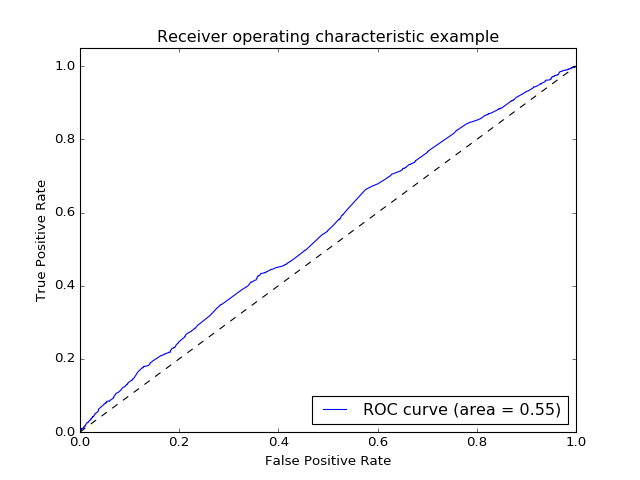


FOR: AdaB
             precision    recall  f1-score   support

          0       0.53      0.34      0.41      1581
          1       0.56      0.73      0.63      1791

avg / total       0.54      0.55      0.53      3372

[[ 532 1049]
 [ 481 1310]]
F1:  0.631325301205
Precision:  0.714700158881
Recall:  0.73143495254
Accuracy: 0.538 (+/- 0.02) [AdaB]
Accuracy score:  0.546263345196
0.49385906269


<IPython.core.display.Javascript object>


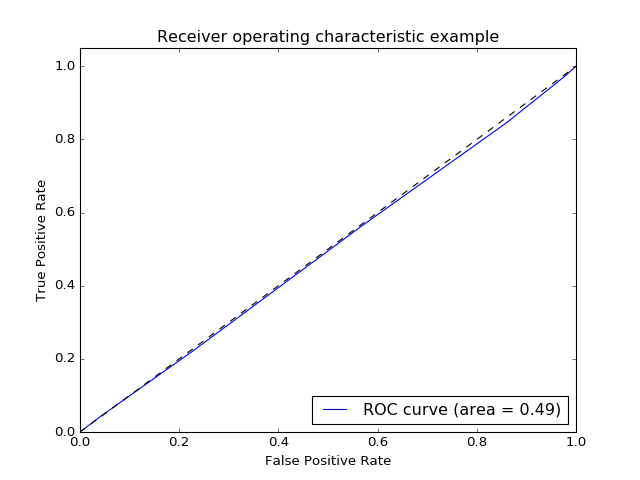


FOR: kNN
             precision    recall  f1-score   support

          0       0.47      0.43      0.45      1581
          1       0.53      0.56      0.55      1791

avg / total       0.50      0.50      0.50      3372

[[ 683  898]
 [ 782 1009]]
F1:  0.545700378583
Precision:  0.662192783525
Recall:  0.563372417644
Accuracy: 0.509 (+/- 0.02) [kNN]
Accuracy score:  0.501779359431


In [18]:
train_test_at_once(nick_names, classifiers, "trait_agr", train_feat_agr, test_feat_agr, train_class_agr, test_class_agr, agr_X, agr_Y, skf_agr)

### Train + Test OPN

0.536324599253


<IPython.core.display.Javascript object>


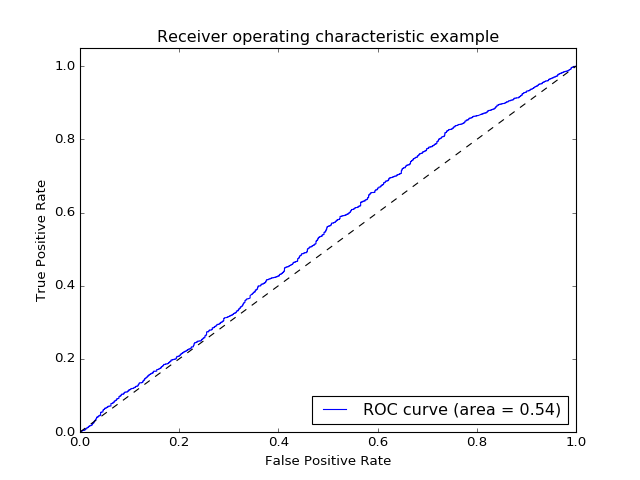


FOR: SVC
             precision    recall  f1-score   support

          0       0.42      0.01      0.01       866
          1       0.74      1.00      0.85      2506

avg / total       0.66      0.74      0.64      3372

[[   5  861]
 [   7 2499]]
F1:  0.852028639618
Precision:  0.871516311623
Recall:  0.997206703911
Accuracy: 0.740 (+/- 0.02) [SVC]
Accuracy score:  0.742586002372

FOR: LinearSVC
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       866
          1       0.74      1.00      0.85      2506

avg / total       0.55      0.74      0.63      3372

[[   0  866]
 [   0 2506]]
F1:  0.852670976523
Precision:  0.871589561091
Recall:  1.0
Accuracy: 0.660 (+/- 0.32) [LinearSVC]
Accuracy score:  0.743179122183
0.547043216373


<IPython.core.display.Javascript object>


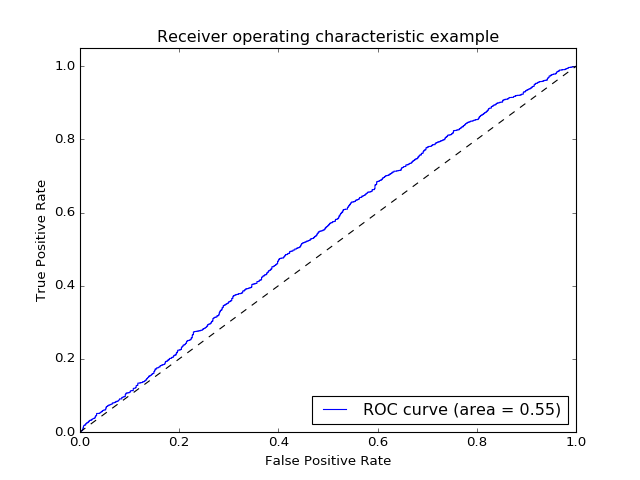


FOR: Multinomia-NB
             precision    recall  f1-score   support

          0       0.62      0.02      0.03       866
          1       0.75      1.00      0.85      2506

avg / total       0.71      0.74      0.64      3372

[[  13  853]
 [   8 2498]]
F1:  0.852996414547
Precision:  0.872314630259
Recall:  0.996807661612
Accuracy: 0.730 (+/- 0.03) [Multinomia-NB]
Accuracy score:  0.744661921708
0.551835410258


<IPython.core.display.Javascript object>


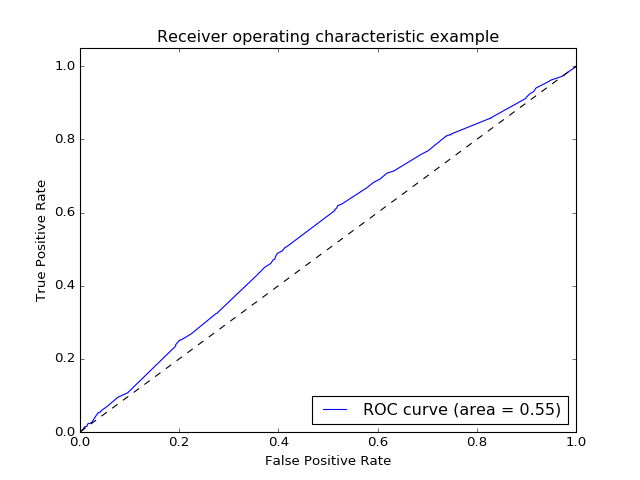


FOR: Bernoulli-NB
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       866
          1       0.74      1.00      0.85      2506

avg / total       0.55      0.74      0.63      3372

[[   0  866]
 [   0 2506]]
F1:  0.852670976523
Precision:  0.871589561091
Recall:  1.0
Accuracy: 0.743 (+/- 0.02) [Bernoulli-NB]
Accuracy score:  0.743179122183
0.560773773429


<IPython.core.display.Javascript object>


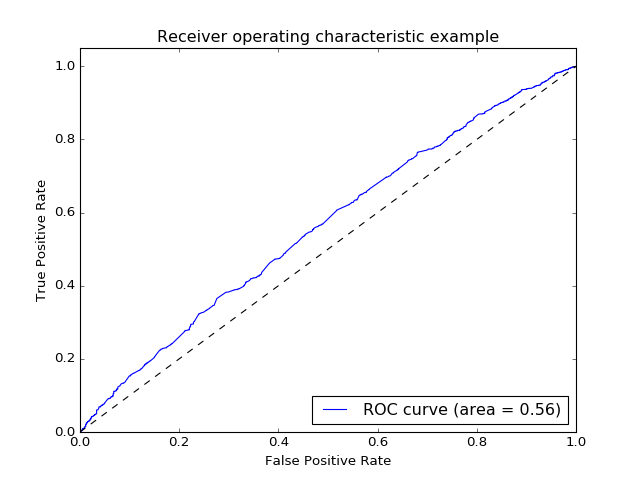


FOR: RF
             precision    recall  f1-score   support

          0       0.25      0.00      0.00       866
          1       0.74      1.00      0.85      2506

avg / total       0.62      0.74      0.63      3372

[[   1  865]
 [   3 2503]]
F1:  0.852230166837
Precision:  0.871431787099
Recall:  0.998802873105
Accuracy: 0.743 (+/- 0.02) [RF]
Accuracy score:  0.742586002372
0.570671496952


<IPython.core.display.Javascript object>


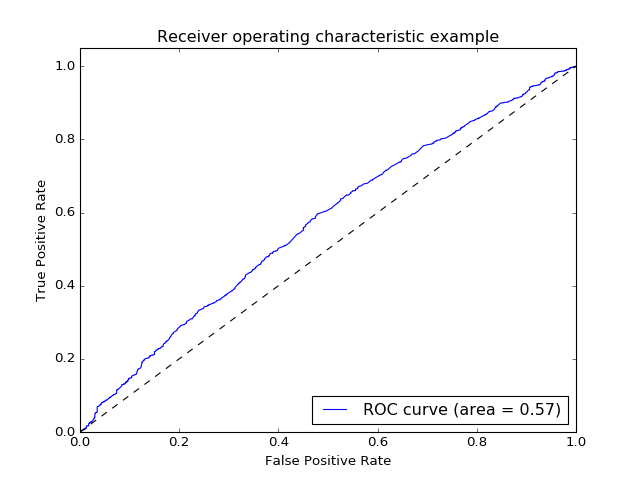


FOR: AdaB
             precision    recall  f1-score   support

          0       0.41      0.01      0.02       866
          1       0.74      0.99      0.85      2506

avg / total       0.66      0.74      0.64      3372

[[  11  855]
 [  16 2490]]
F1:  0.851136557853
Precision:  0.87137745027
Recall:  0.993615323224
Accuracy: 0.742 (+/- 0.03) [AdaB]
Accuracy score:  0.741696322657
0.508265843269


<IPython.core.display.Javascript object>


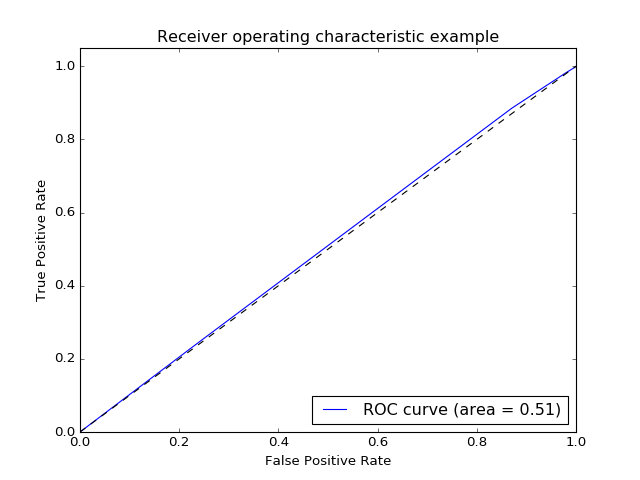


FOR: kNN
             precision    recall  f1-score   support

          0       0.28      0.13      0.18       866
          1       0.75      0.89      0.81      2506

avg / total       0.63      0.69      0.65      3372

[[ 112  754]
 [ 287 2219]]
F1:  0.810001825151
Precision:  0.85848583844
Recall:  0.885474860335
Accuracy: 0.693 (+/- 0.03) [kNN]
Accuracy score:  0.69128113879


In [19]:
train_test_at_once(nick_names, classifiers, "trait_opn", train_feat_opn, test_feat_opn, train_class_opn, test_class_opn, opn_X, opn_Y, skf_opn)